## Data Science Class with Onoja Anthony, PhD (Email: donmaston09@gmail.com)
### Follow our Page on FaceBook: DataEdge Academy
#### Subscribe to our YouTube channel: @tonyonoja7880

#### Note: to run this script, you have to install the relevant Python packages and the datasets.

### Introduction

Clustering is all about grouping similar data points together based on their features. Clustering finds these groups without being told what they should be.
 Common Clustering Algorithms we will be looking at include:

 - K-Means Clustering: K-Means clustering is a centroid-based method for grouping data points into k clusters based on similarity.
 - Hierarchical Clustering: Hierarchical clustering builds a hierarchy of clusters, useful for understanding data structure at different levels.
 - DBSCAN: DBSCAN, a density-based clustering algorithm, identifies clusters of arbitrary shapes and handles noise well.


In [151]:
#!pip install kagglehub # install the necessary package 

In [152]:
# Load the required packages
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.preprocessing import StandardScaler
import kagglehub
import zipfile
import os
import warnings

# Suppress all warnings
warnings.filterwarnings('ignore')

In [153]:
# Download latest version
path = kagglehub.dataset_download("camnugent/sandp500")

csv_file_path = os.path.join(path, "all_stocks_5yr.csv") #or what ever the csv file is called.
df = pd.read_csv(csv_file_path)

df.head()

,date,open,high,low,close,volume,Name
0,2013-02-08,15.07,15.12,14.63,14.75,8407500,AAL
1,2013-02-11,14.89,15.01,14.26,14.46,8882000,AAL
2,2013-02-12,14.45,14.51,14.10,14.27,8126000,AAL
3,2013-02-13,14.30,14.94,14.25,14.66,10259500,AAL
4,2013-02-14,14.94,14.96,13.16,13.99,31879900,AAL


#### Step 1: Exploratory Data Analysis Phase

In [154]:
# Convert date column to datetime format
df['date'] = pd.to_datetime(df['date'])

In [155]:
# Basic information about the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 619040 entries, 0 to 619039
Data columns (total 7 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   date    619040 non-null  datetime64[ns]
 1   open    619029 non-null  float64       
 2   high    619032 non-null  float64       
 3   low     619032 non-null  float64       
 4   close   619040 non-null  float64       
 5   volume  619040 non-null  int64         
 6   Name    619040 non-null  object        
dtypes: datetime64[ns](1), float64(4), int64(1), object(1)
memory usage: 33.1+ MB


In [156]:
df.describe() # check for descriptive statistics 

,date,open,high,low,close,volume
count,619040,619029.000000,619032.000000,619032.000000,619040.000000,6.190400e+05
mean,2015-08-18 00:48:23.494443264,83.023334,83.778311,82.256096,83.043763,4.321823e+06
min,2013-02-08 00:00:00,1.620000,1.690000,1.500000,1.590000,0.000000e+00
25%,2014-05-20 00:00:00,40.220000,40.620000,39.830000,40.245000,1.070320e+06
50%,2015-08-21 00:00:00,62.590000,63.150000,62.020000,62.620000,2.082094e+06
75%,2016-11-15 00:00:00,94.370000,95.180000,93.540000,94.410000,4.284509e+06
max,2018-02-07 00:00:00,2044.000000,2067.990000,2035.110000,2049.000000,6.182376e+08
std,NaN,97.378769,98.207519,96.507421,97.389748,8.693610e+06


In [157]:
# Check for missing values
print("Missing values:\n", df.isnull().sum())

Missing values:
 date       0
open      11
high       8
low        8
close      0
volume     0
Name       0
dtype: int64


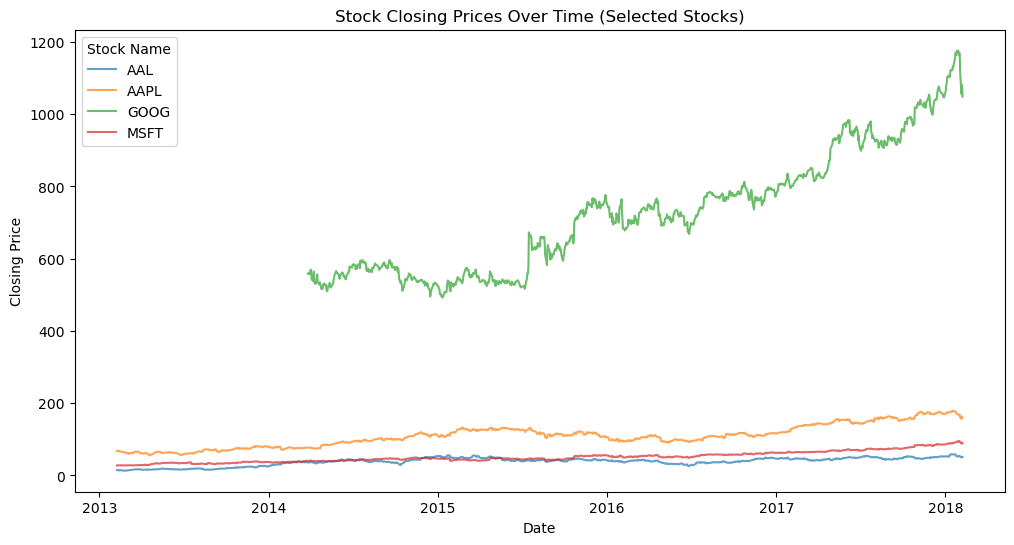

In [158]:
selected_stocks = [ 'AAL', 'AAPL', 'GOOG', 'MSFT']  # Choose the stocks you want to highlight
filtered_df = df[df['Name'].isin(selected_stocks)]

plt.figure(figsize=(12, 6))
sns.lineplot(data=filtered_df, x='date', y='close', hue='Name', alpha=0.7)
plt.title("Stock Closing Prices Over Time (Selected Stocks)")
plt.xlabel("Date")
plt.ylabel("Closing Price")
plt.legend(title="Stock Name")
plt.show()

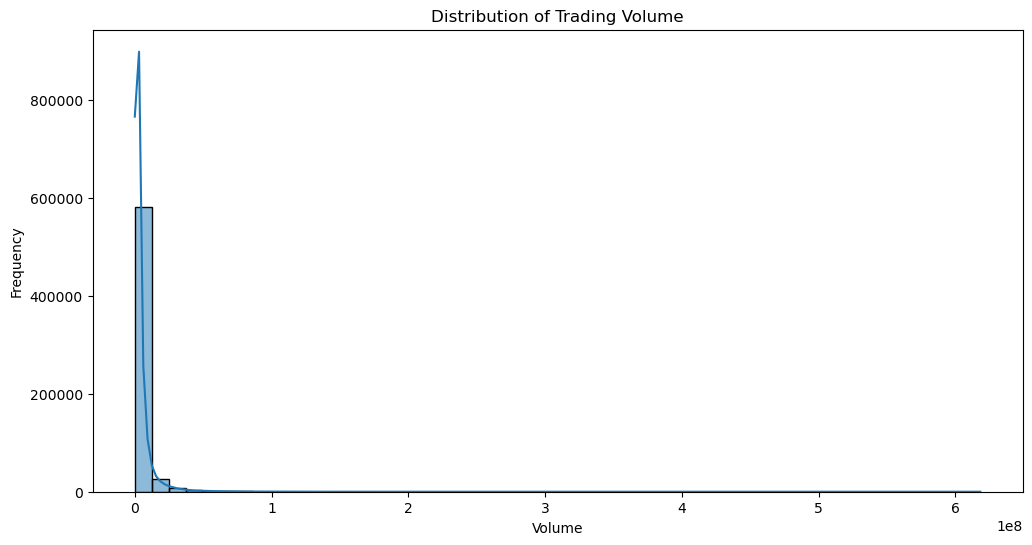

In [159]:
# Distribution of stock volumes
plt.figure(figsize=(12, 6))
sns.histplot(df['volume'], bins=50, kde=True)
plt.title("Distribution of Trading Volume")
plt.xlabel("Volume")
plt.ylabel("Frequency")
plt.show()

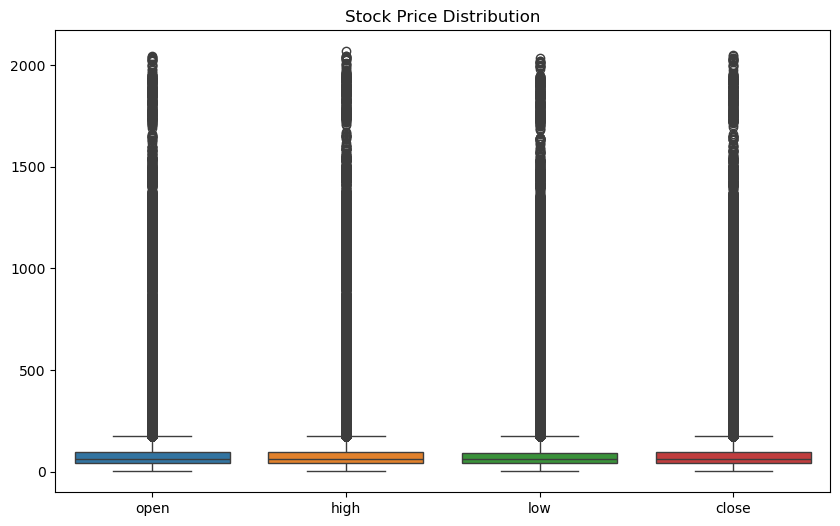

In [160]:
# Boxplot to check for outliers in stock prices
plt.figure(figsize=(10, 6))
sns.boxplot(data=df[['open', 'high', 'low', 'close']])
plt.title("Stock Price Distribution")
plt.show()

In [161]:
### Handle Missing values 

#Using the Median (Robust to Outliers) for numeric variable only 
df['open'] = df['open'].fillna(df['open'].median())

df['high'] = df['high'].fillna(df['high'].median())

df['low'] = df['low'].fillna(df['low'].median())

In [162]:
# Filter by year
year_to_cluster = 2016  # Or which ever year you want to cluster.
df_year = df[df['date'].dt.year == year_to_cluster].copy()

In [163]:
# Calculate daily percentage change
df_year['daily_change'] = df_year.groupby('Name')['close'].pct_change() * 100
df_year.dropna(inplace=True)  # remove the first day of each stock.

In [164]:
# Pivot the data
pivot_df = df_year.pivot(index='Name', columns='date', values='daily_change')

# Handle NaNs after pivoting
pivot_df.fillna(0, inplace=True)  # Replace NaNs with 0 (or use mean/median)

In [165]:
# Scale the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(pivot_df)

#### KMeans Clustering

In [166]:
# K-Means Clustering
from sklearn.cluster import KMeans
num_clusters = 3  # Choose the number of clusters
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
clusters = kmeans.fit_predict(scaled_data)

In [167]:
# Add clusters to DataFrame
pivot_df['Cluster'] = clusters

# Analyze clusters (example: mean daily change by cluster)
cluster_analysis = pivot_df.groupby('Cluster').mean()
print(cluster_analysis)

date     2016-01-05  2016-01-06  2016-01-07  2016-01-08  2016-01-11  \
Cluster                                                               
0         -0.093609   -7.123181   -3.193645    0.087716   -4.703668   
1          0.651674   -0.866806   -1.690601   -0.887391    0.126726   
2         -0.282964   -2.034272   -2.923671   -1.772658   -0.326251   

date     2016-01-12  2016-01-13  2016-01-14  2016-01-15  2016-01-19  ...  \
Cluster                                                              ...   
0         -2.414638   -3.162374    4.959114   -3.887262   -3.969434  ...   
1          0.698735   -1.982171    1.235815   -1.365622    0.348507  ...   
2          0.790274   -3.407928    1.154944   -2.435965   -0.708272  ...   

date     2016-12-16  2016-12-19  2016-12-20  2016-12-21  2016-12-22  \
Cluster                                                               
0         -0.312520   -0.401569   -0.228974    0.420315   -0.065004   
1          0.226815    0.233567    0.137961   -0.3

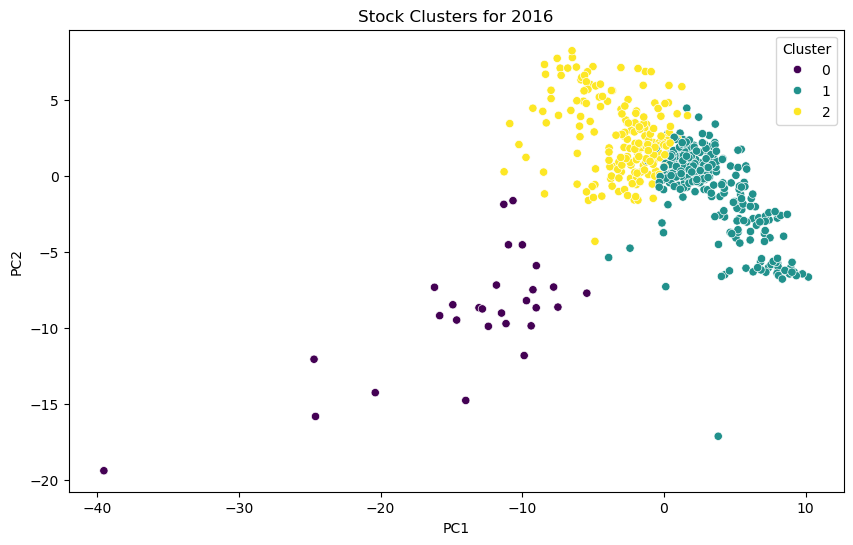

In [168]:
# Visualize the clusters, using only 2 features.
from sklearn.decomposition import PCA
pca = PCA(n_components=2) # Apply Principal Component Analysis (PCA)
reduced_features = pca.fit_transform(scaled_data)
reduced_df = pd.DataFrame(reduced_features, columns=['PC1', 'PC2'])
reduced_df['Cluster'] = clusters

plt.figure(figsize=(10, 6))
sns.scatterplot(data=reduced_df, x='PC1', y='PC2', hue='Cluster', palette='viridis')
plt.title(f"Stock Clusters for {year_to_cluster}")
plt.show()

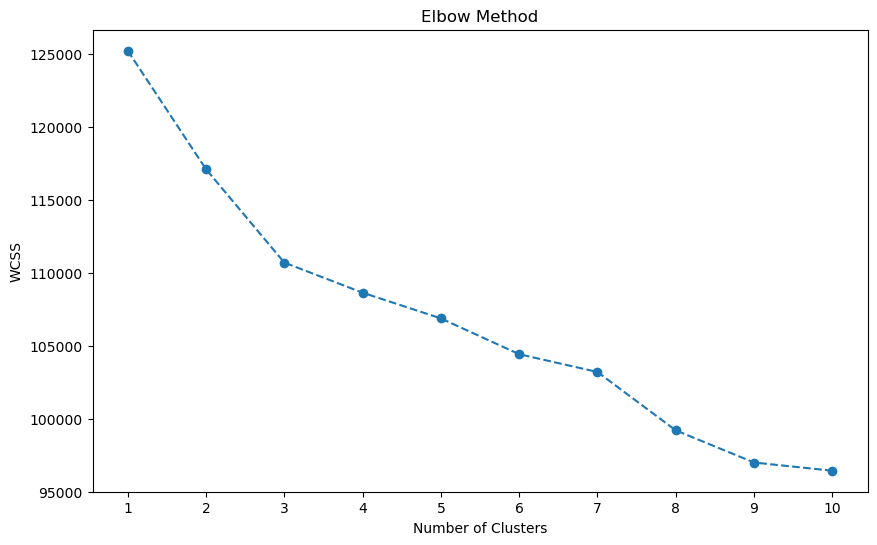

In [169]:
### Elbow Method: Determine Optimal Cluster number 

wcss = []  # Within-cluster sum of squares
for i in range(1, 11):  # Test clusters from 1 to 10
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(scaled_data)
    wcss.append(kmeans.inertia_)  # inertia_ stores the WCSS

# Plot the Elbow Method
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), wcss, marker='o', linestyle='--')
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.xticks(range(1, 11))
#plt.grid(True)
plt.show()

The optimal cluster appears to kneel around 3

Sharp Decrease Then Plateau: The WCSS (Within-Cluster Sum of Squares) decreases sharply from 1 to 3 clusters. After 3 clusters, the rate of decrease slows down significantly, creating an "elbow" in the plot.

Diminishing Returns: Adding more clusters beyond 3 doesn't seem to provide a substantial reduction in WCSS, suggesting that the additional clusters might not be adding much valuable information.

Therefore, 3 clusters would be a reasonable choice for this data based on the Elbow Method.

date     2016-01-05  2016-01-06  2016-01-07  2016-01-08  2016-01-11  \
Cluster                                                               
0         -0.093609   -7.123181   -3.193645    0.087716   -4.703668   
1          0.651674   -0.866806   -1.690601   -0.887391    0.126726   
2         -0.282964   -2.034272   -2.923671   -1.772658   -0.326251   

date     2016-01-12  2016-01-13  2016-01-14  2016-01-15  2016-01-19  ...  \
Cluster                                                              ...   
0         -2.414638   -3.162374    4.959114   -3.887262   -3.969434  ...   
1          0.698735   -1.982171    1.235815   -1.365622    0.348507  ...   
2          0.790274   -3.407928    1.154944   -2.435965   -0.708272  ...   

date     2016-12-16  2016-12-19  2016-12-20  2016-12-21  2016-12-22  \
Cluster                                                               
0         -0.312520   -0.401569   -0.228974    0.420315   -0.065004   
1          0.226815    0.233567    0.137961   -0.3

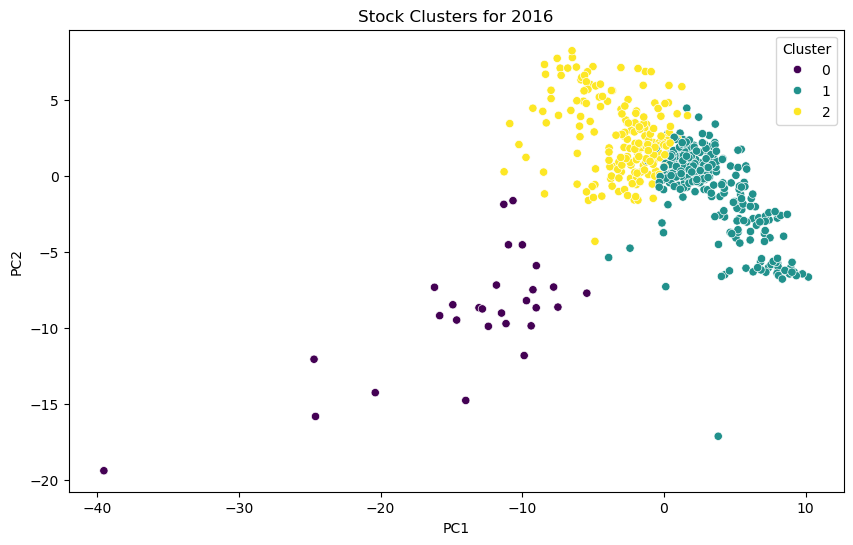

In [170]:
#After inspecting the elbow method graph, select the number of clusters.
num_clusters = 3 # optimal number of clusters.

kmeans = KMeans(n_clusters=num_clusters, random_state=42)
clusters = kmeans.fit_predict(scaled_data)

# Add clusters to DataFrame
pivot_df['Cluster'] = clusters

# Analyze clusters
cluster_analysis = pivot_df.groupby('Cluster').mean()
print(cluster_analysis)

# Visualize the clusters
pca = PCA(n_components=2)
reduced_features = pca.fit_transform(scaled_data)
reduced_df = pd.DataFrame(reduced_features, columns=['PC1', 'PC2'])
reduced_df['Cluster'] = clusters

plt.figure(figsize=(10, 6))
sns.scatterplot(data=reduced_df, x='PC1', y='PC2', hue='Cluster', palette='viridis')
plt.title(f"Stock Clusters for {year_to_cluster}")
plt.show()

### Exercise

Repeat the same procedure with a different Year e.g., 2018

### Example 2: Breast Cancer Wisconsin (Diagnostic) Dataset

#### Introduction
Source: This dataset is from the University of Wisconsin Hospitals, Madison, and was created by Dr. William H. Wolberg.
Purpose: It's designed to help diagnose breast cancer as either benign (non-cancerous) or malignant (cancerous) based on features derived from digitized images of fine needle aspirates (FNAs) of breast masses.
#### Features:
The dataset contains 30 features, which are essentially characteristics of the cell nuclei present in the breast mass.
These features are calculated from a digitized image of the FNA, and they describe various attributes of the cell nuclei, such as:
Radius (mean of distances from center to points on the perimeter)
Texture (standard deviation of gray-scale values)
Perimeter
Area
Smoothness (local variation in radius lengths)
Compactness 
Concavity (severity of concave portions of the contour)
Concave points (number of concave portions of the contour)
Symmetry
Fractal dimension 
1.
bookdown.org
bookdown.org
Each of these 10 features are given in 3 ways. Mean, Standard Error, and worst or largest.
Target Variable:
The dataset includes a target variable (diagnosis) that indicates whether a tumor is benign (B) or malignant (M).
Why Perform Clustering on This Dataset?

While the dataset already has a target variable (diagnosis), clustering can still provide valuable insights and have practical applications:

- Exploring Underlying Patterns: Clustering can reveal natural groupings within the data, even beyond the simple benign/malignant classification.
For example, it might identify subtypes of malignant tumors based on their feature characteristics.
This can help researchers find new relationships between the features, and the types of cancer.
- Unsupervised Learning Insights: Clustering is an unsupervised learning technique, meaning it doesn't rely on labeled data.
This can be useful when you want to explore the data without pre-existing knowledge or when labels are unreliable.
If for some reason the labels were removed, or corrupted, clustering could still provide some information about the data.


In [171]:
from sklearn.datasets import load_breast_cancer 
# Load the dataset
breast_cancer = load_breast_cancer()
df_cancer = pd.DataFrame(breast_cancer.data, columns=breast_cancer.feature_names)


In [172]:
# Perform some EDA
print("Breast Cancer Data:")
df_cancer.head()

Breast Cancer Data:


,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [173]:
df_cancer.describe()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
count,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,...,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,0.062798,...,16.269190,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946
std,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,0.007060,...,4.833242,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061
min,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,0.049960,...,7.930000,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040
25%,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,0.057700,...,13.010000,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460
50%,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,0.061540,...,14.970000,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040
75%,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,0.066120,...,18.790000,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080
max,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,0.097440,...,36.040000,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500


In [174]:
df_cancer.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 30 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   mean radius              569 non-null    float64
 1   mean texture             569 non-null    float64
 2   mean perimeter           569 non-null    float64
 3   mean area                569 non-null    float64
 4   mean smoothness          569 non-null    float64
 5   mean compactness         569 non-null    float64
 6   mean concavity           569 non-null    float64
 7   mean concave points      569 non-null    float64
 8   mean symmetry            569 non-null    float64
 9   mean fractal dimension   569 non-null    float64
 10  radius error             569 non-null    float64
 11  texture error            569 non-null    float64
 12  perimeter error          569 non-null    float64
 13  area error               569 non-null    float64
 14  smoothness error         5

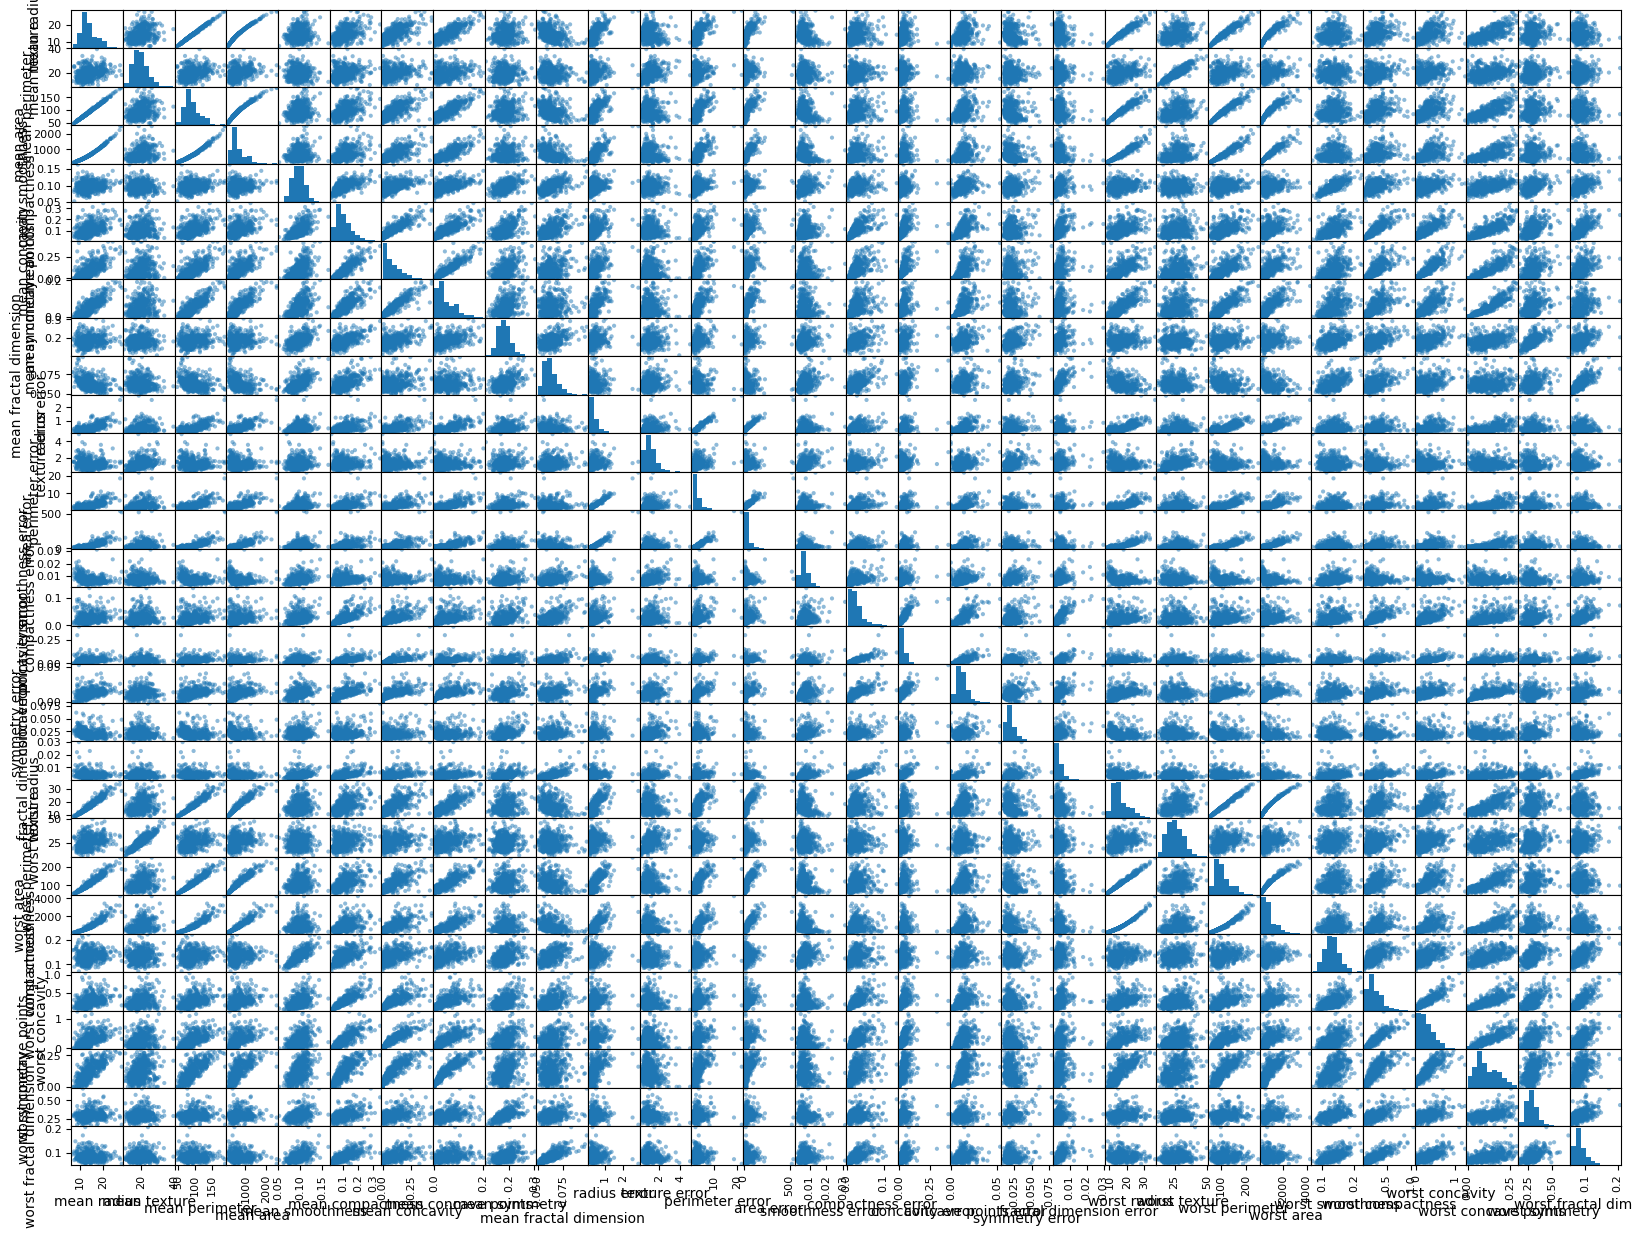

In [175]:
from pandas.plotting import scatter_matrix
#df_1 = ['mean radius', 'mean texture'...]
scatter_matrix(df_cancer, figsize=(20, 15))
plt.show()

In [176]:
# Standardize the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df_cancer)

In [177]:
# Apply PCA for visualization
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(scaled_data)
df_pca = pd.DataFrame(reduced_data, columns=['PC1', 'PC2'])

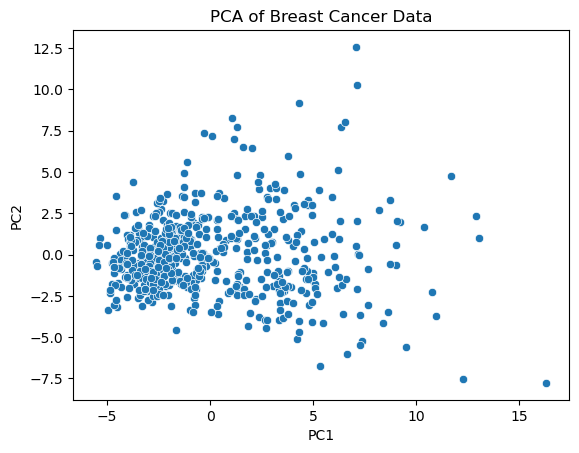

In [178]:
sns.scatterplot(x='PC1', y='PC2', data=df_pca)
plt.title('PCA of Breast Cancer Data')
plt.show()

In [179]:
# K-Means Clustering
kmeans = KMeans(n_clusters=3, random_state=42)  # Assuming two clusters (malignant/benign)
clusters = kmeans.fit_predict(scaled_data)
df_pca['Cluster'] = clusters


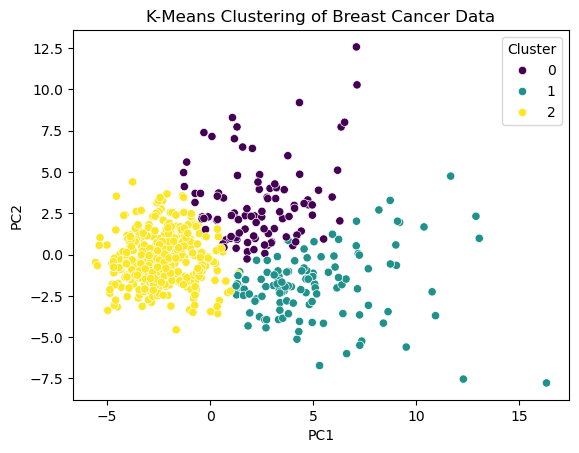

In [180]:
sns.scatterplot(x='PC1', y='PC2', hue='Cluster', data=df_pca, palette='viridis')
plt.title('K-Means Clustering of Breast Cancer Data')
plt.show()

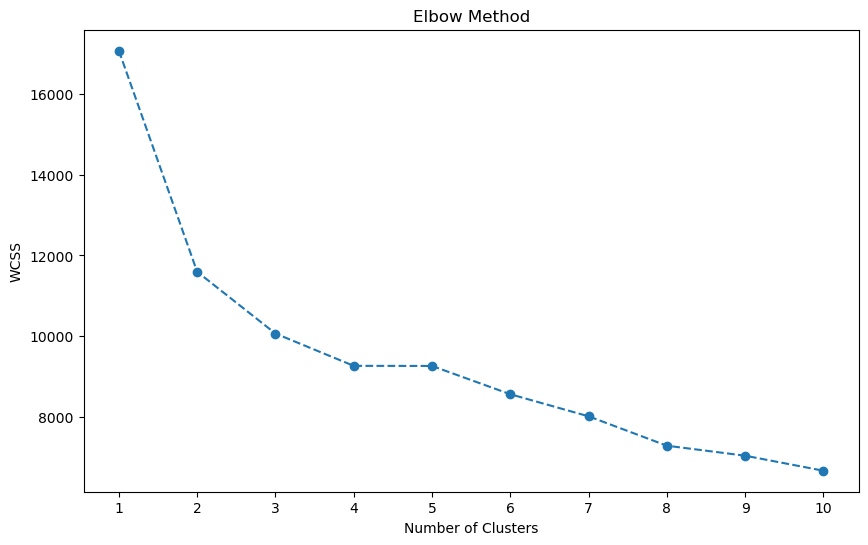

In [181]:
### Elbow Method: Determine Optimal Cluster number 

wcss = []  # Within-cluster sum of squares
for i in range(1, 11):  # Test clusters from 1 to 10
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(scaled_data)
    wcss.append(kmeans.inertia_)  # inertia_ stores the WCSS

# Plot the Elbow Method
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), wcss, marker='o', linestyle='--')
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.xticks(range(1, 11))
#plt.grid(True)
plt.show()

#### Hierarchical Clustering

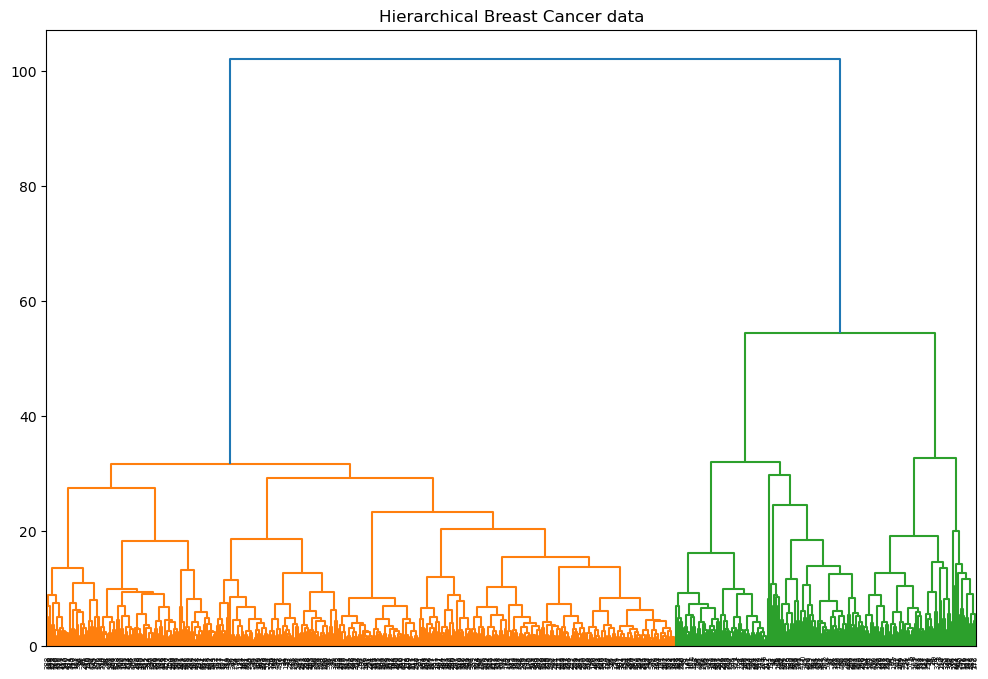

In [182]:
from scipy.cluster.hierarchy import dendrogram, linkage

# Apply Hierarchical Clustering 
linked = linkage(scaled_data, 'ward')

# Dendrogram
plt.figure(figsize=(12, 8))
dendrogram(linked, orientation='top', labels=df_cancer.index) #Use the index of the sampled dataframe.
plt.title('Hierarchical Breast Cancer data')
plt.show()

#### Visualise the dendogram based on columns 

In [183]:
# Create a DataFrame from the scaled data, for better column indexing.
scaled_df = pd.DataFrame(scaled_data, columns=df_cancer.columns)

# Transpose the DataFrame (columns become rows)
transposed_data = scaled_df.T

# Apply Hierarchical Clustering to the transposed data
linked = linkage(transposed_data, 'ward')

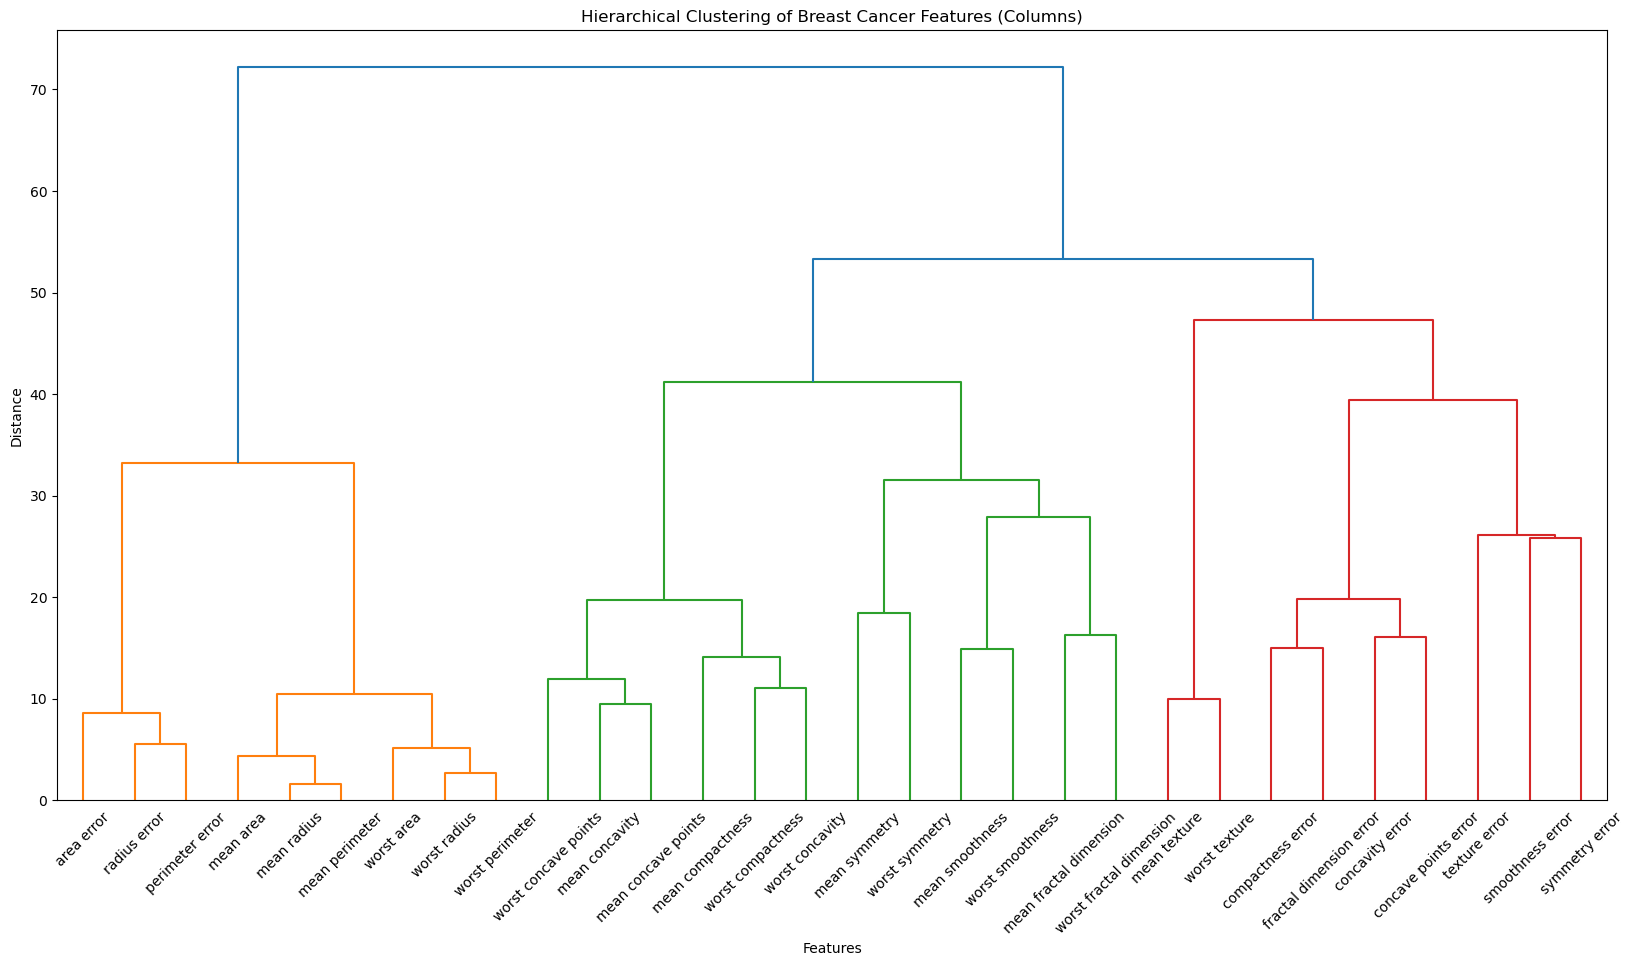

In [184]:
# Dendrogram for column clustering
plt.figure(figsize=(20, 10))  # Adjust figure size for better visualization
dendrogram(linked, orientation='top', labels=transposed_data.index)
plt.title('Hierarchical Clustering of Breast Cancer Features (Columns)')
plt.xlabel('Features')
plt.ylabel('Distance')
plt.show()

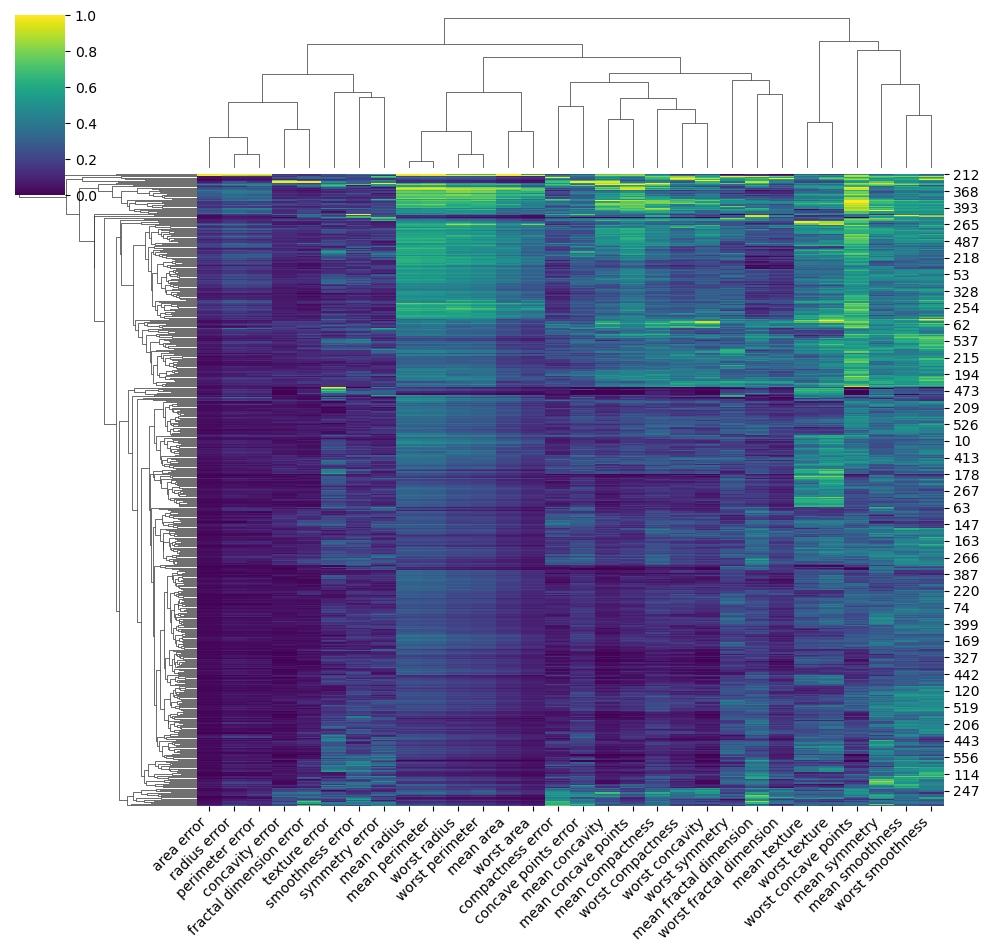

In [185]:
# Create the clustering heatmap
clustermap = sns.clustermap(scaled_df, cmap='viridis', standard_scale=1)  # standard_scale=1 scales the columns.
#clustermap.fig.suptitle('Clustering Heatmap of Breast Cancer Data', fontsize=16)

# Slant the labels on the x-axis
plt.setp(clustermap.ax_heatmap.xaxis.get_majorticklabels(), rotation=45, ha='right')

plt.show()

### Exercise 

#### Mental Heath Analysis Among Teenagers dataset 

This dataset explores teenage mental health, specifically stress levels, through analysis of anonymized social media, survey, and wearable device data. Comprising 5000 entries and 11 columns, it aims to uncover correlations between daily behaviors (social media, activity, sleep) and stress. The dataset supports research on adolescent mental health, early stress detection, and preventive strategies.

link: https://www.kaggle.com/datasets/aniruddhawankhede/mental-heath-analysis-among-teenagers

Task: Apply the KMeans Clustering and Hierarchical Clustering to this dataset

Report your findings and deduction.

#### DBSCAN Clustering Approach 

In [186]:
from sklearn.cluster import DBSCAN

In [187]:
# Apply DBSCAN
dbscan = DBSCAN(eps=3, min_samples=5)  # Adjust eps and min_samples as needed
clusters = dbscan.fit_predict(scaled_data)

In [188]:
# Remap cluster labels (outliers to a positive label)
unique_labels = sorted(list(set(clusters)))
remapped_clusters = clusters.copy()
cluster_count = 0  # To keep track of cluster labels

for label in unique_labels:
    if label == -1:
        remapped_clusters[clusters == label] = cluster_count #Assign the outliers their own cluster.
        cluster_count +=1
    elif label != -1:
        remapped_clusters[clusters == label] = cluster_count
        cluster_count +=1

In [189]:
# Add cluster labels to the DataFrame
df_cancer['Cluster'] = remapped_clusters

In [190]:
# Visualize the clusters (using PCA for 2D representation)
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(scaled_data)
df_pca = pd.DataFrame(reduced_data, columns=['PC1', 'PC2'])
df_pca['Cluster'] = remapped_clusters

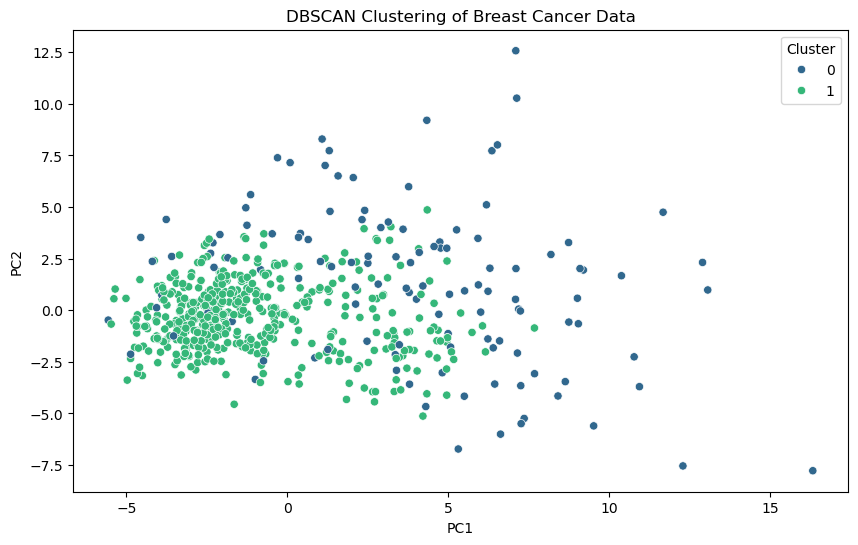

In [191]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='PC1', y='PC2', hue='Cluster', data=df_pca, palette='viridis')
plt.title('DBSCAN Clustering of Breast Cancer Data')
plt.show()

In [192]:
# Display cluster counts
print(df_cancer['Cluster'].value_counts())

Cluster
1    448
0    121
Name: count, dtype: int64


### Anomaly Detection task 

#### Fraud Detection Dataset

Description:
Fraudulent transactions are a growing challenge for fintech companies. This dataset captures 51,000+ transactions, each labeled as fraudulent or legitimate, based on real-world patterns.

It includes transaction details, user behavior, payment methods, and device usage, making it ideal for:
                                                                                                                                                           - Fraud detection modeling (classification)
- Feature engineering & anomaly detection

#### Columns Overview:
- Transaction Details: Amount, type, time, and payment method 
- User Behavior: Past fraud history, account age, recent activity 
- Device & Location: Device used, transaction location 

In [193]:
# Download latest version

path = kagglehub.dataset_download("ranjitmandal/fraud-detection-dataset-csv")

csv_file_path = os.path.join(path, "Fraud Detection Dataset.csv") #Load the dataset from Kaggle.
df = pd.read_csv(csv_file_path, index_col = 0)

df.head()

,User_ID,Transaction_Amount,Transaction_Type,Time_of_Transaction,Device_Used,Location,Previous_Fraudulent_Transactions,Account_Age,Number_of_Transactions_Last_24H,Payment_Method,Fraudulent
Transaction_ID,,,,,,,,,,,
T1,4174,1292.76,ATM Withdrawal,16.0,Tablet,San Francisco,0,119,13,Debit Card,0
T2,4507,1554.58,ATM Withdrawal,13.0,Mobile,New York,4,79,3,Credit Card,0
T3,1860,2395.02,ATM Withdrawal,NaN,Mobile,NaN,3,115,9,NaN,0
T4,2294,100.10,Bill Payment,15.0,Desktop,Chicago,4,3,4,UPI,0
T5,2130,1490.50,POS Payment,19.0,Mobile,San Francisco,2,57,7,Credit Card,0


In [194]:
# Reset the index
df = df.reset_index(drop=True)

### Perform EDA 

In [195]:
# Display basic information
print("Data Info:")
print(df.info())

Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51000 entries, 0 to 50999
Data columns (total 11 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   User_ID                           51000 non-null  int64  
 1   Transaction_Amount                48480 non-null  float64
 2   Transaction_Type                  51000 non-null  object 
 3   Time_of_Transaction               48448 non-null  float64
 4   Device_Used                       48527 non-null  object 
 5   Location                          48453 non-null  object 
 6   Previous_Fraudulent_Transactions  51000 non-null  int64  
 7   Account_Age                       51000 non-null  int64  
 8   Number_of_Transactions_Last_24H   51000 non-null  int64  
 9   Payment_Method                    48531 non-null  object 
 10  Fraudulent                        51000 non-null  int64  
dtypes: float64(2), int64(5), object(4)
memory usage: 4.3+ MB

In [196]:
# Display summary statistics
print("\nSummary Statistics:")
df.describe()


Summary Statistics:


,User_ID,Transaction_Amount,Time_of_Transaction,Previous_Fraudulent_Transactions,Account_Age,Number_of_Transactions_Last_24H,Fraudulent
count,51000.000000,48480.000000,48448.000000,51000.000000,51000.000000,51000.000000,51000.000000
mean,3005.110176,2996.249784,11.488400,1.995725,60.033902,7.495588,0.049216
std,1153.121107,5043.932555,6.922954,1.415150,34.384131,4.020080,0.216320
min,1000.000000,5.030000,0.000000,0.000000,1.000000,1.000000,0.000000
25%,2007.000000,1270.552500,5.000000,1.000000,30.000000,4.000000,0.000000
50%,2996.000000,2524.100000,12.000000,2.000000,60.000000,7.000000,0.000000
75%,4006.000000,3787.240000,17.000000,3.000000,90.000000,11.000000,0.000000
max,4999.000000,49997.800000,23.000000,4.000000,119.000000,14.000000,1.000000


In [197]:
# Check for missing values
print("\nMissing Values:")
print(df.isnull().sum())


Missing Values:
User_ID                                0
Transaction_Amount                  2520
Transaction_Type                       0
Time_of_Transaction                 2552
Device_Used                         2473
Location                            2547
Previous_Fraudulent_Transactions       0
Account_Age                            0
Number_of_Transactions_Last_24H        0
Payment_Method                      2469
Fraudulent                             0
dtype: int64


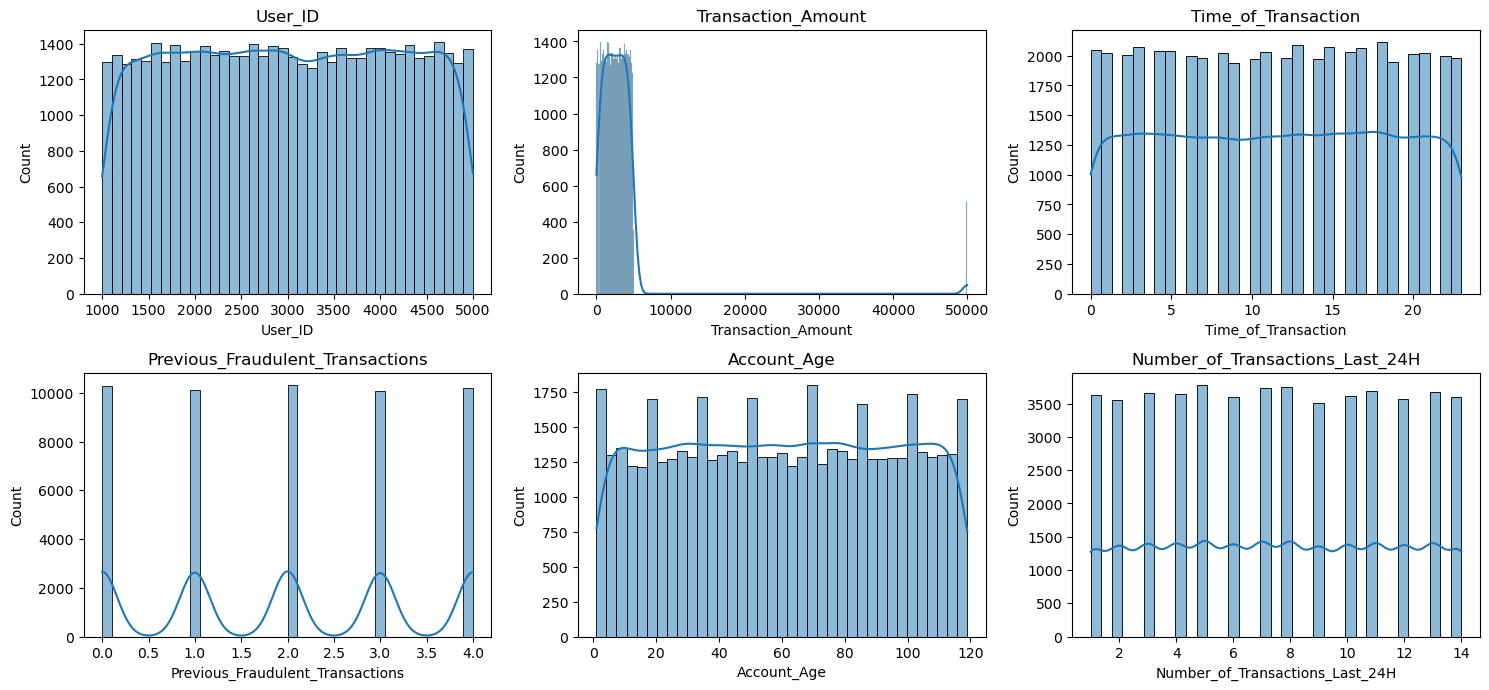

In [198]:
# Visualize distribution of numerical features
import numpy as np
numerical_cols = df.select_dtypes(include=np.number).columns.tolist()
numerical_cols.remove('Fraudulent') #Remove the label, from the numerical columns.
plt.figure(figsize=(15, 10))
for i, col in enumerate(numerical_cols):
    plt.subplot(3, 3, i + 1)
    sns.histplot(df[col], kde=True)
    plt.title(col)
plt.tight_layout()
plt.show()

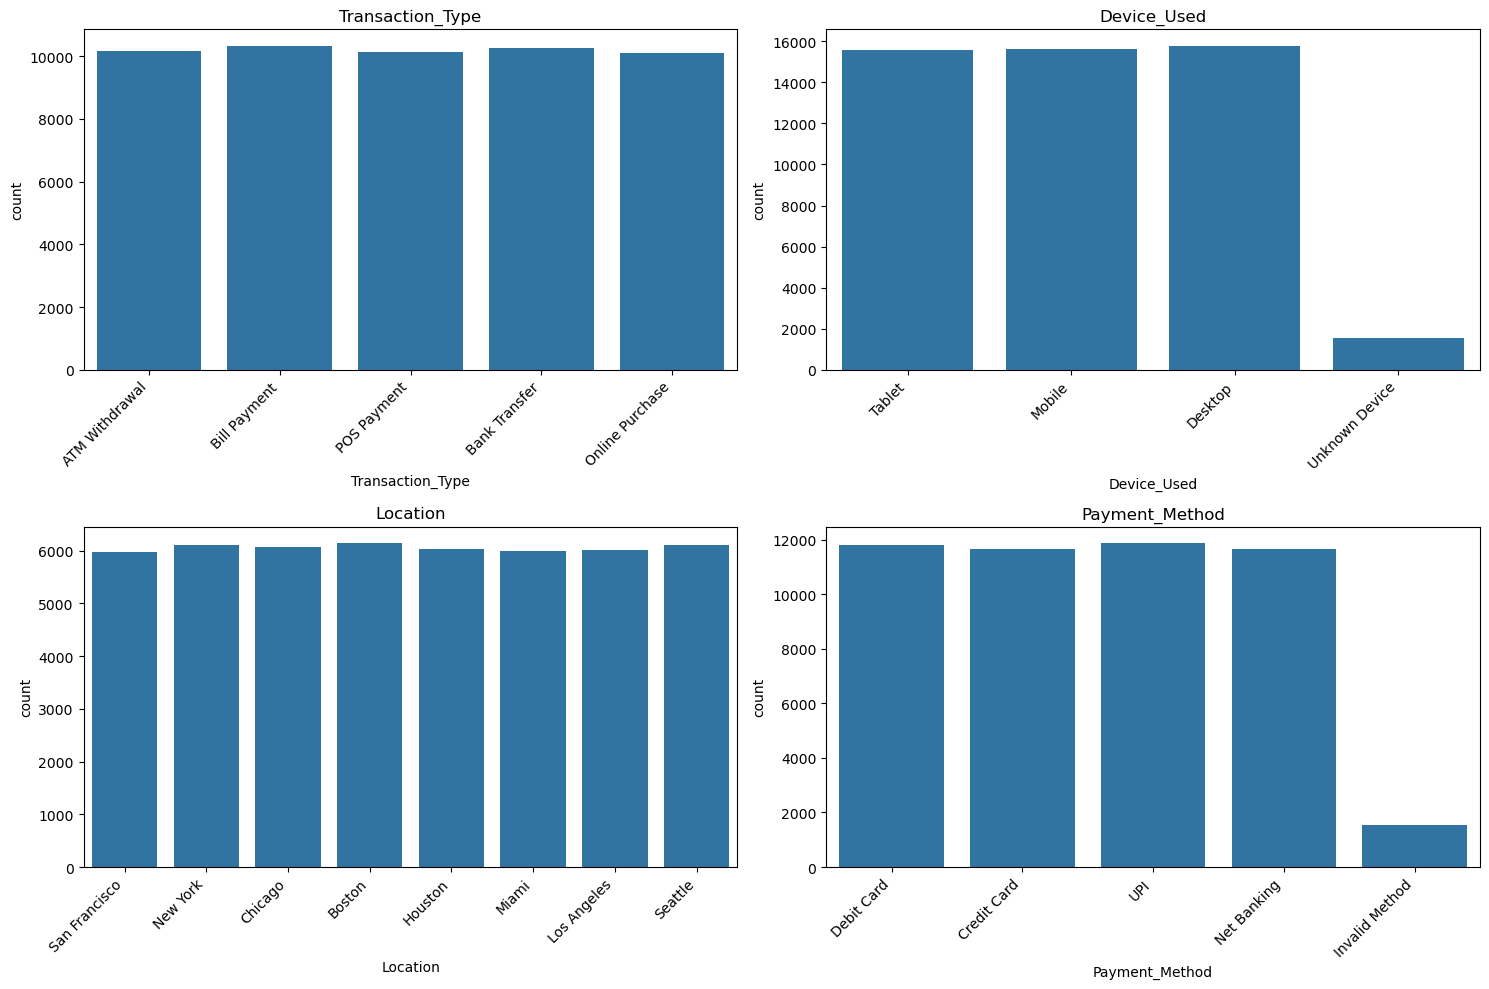

In [199]:
# Visualize distribution of categorical features
categorical_cols = ['Transaction_Type', 'Device_Used', 'Location', 'Payment_Method']
plt.figure(figsize=(15, 10))
for i, col in enumerate(categorical_cols):
    plt.subplot(2, 2, i + 1)
    sns.countplot(x=df[col])
    plt.title(col)
    plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

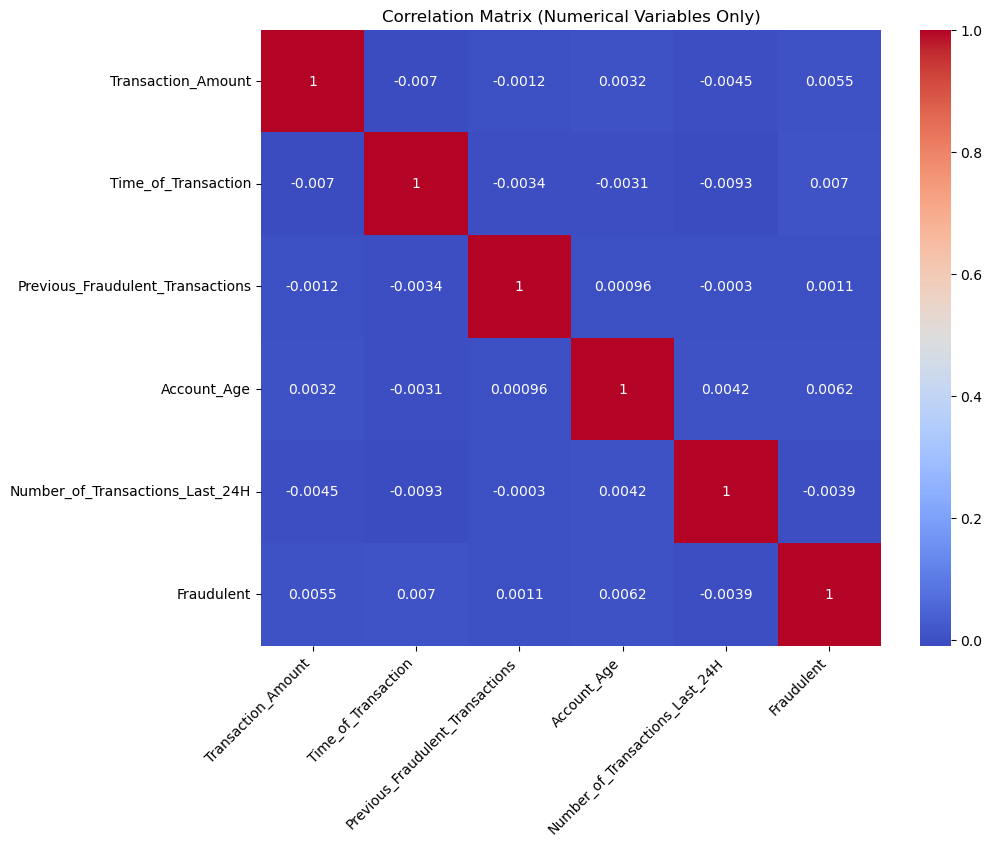

In [200]:
# Select numerical columns
numerical_cols = df.select_dtypes(include=np.number)

numerical_cols  = numerical_cols.drop(columns=['User_ID'])
# Visualize correlation matrix (numerical variables only)
plt.figure(figsize=(10, 8))
sns.heatmap(numerical_cols.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix (Numerical Variables Only)')
plt.xticks(rotation=45, ha='right')
plt.show()

In [201]:
# Handle missing values
for col in df.select_dtypes(include=np.number).columns:
    df[col].fillna(df[col].median(), inplace=True)
for col in df.select_dtypes(include='object').columns:
    df[col].fillna(df[col].mode()[0], inplace=True)

#### Perform Feature Engineering



In [202]:
# Encode categorical features
df  = df.drop(columns=['User_ID'])
# Load the required packages 
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder

# perform some feature transformation
ct = ColumnTransformer(transformers=[('encoder', OneHotEncoder(), categorical_cols)], remainder='passthrough')
encoded_data = ct.fit_transform(df)
encoded_df = pd.DataFrame(encoded_data)

In [203]:
encoded_df.head()

,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,24,25,26,27
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1292.76,16.0,0.0,119.0,13.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1554.58,13.0,4.0,79.0,3.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,2395.02,12.0,3.0,115.0,9.0,0.0
3,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,100.10,15.0,4.0,3.0,4.0,0.0
4,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1490.50,19.0,2.0,57.0,7.0,0.0


In [204]:
# Perform Feature Scaling
scaler = StandardScaler()
scaled_data = scaler.fit_transform(encoded_df)

#### Anomaly Detection



In [205]:
from sklearn.ensemble import IsolationForest
iso_forest = IsolationForest(contamination=0.05, random_state=42)
anomalies = iso_forest.fit_predict(scaled_data)

In [206]:
# Add anomaly labels
df['Anomaly'] = anomalies

In [207]:
# Visualisation
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(scaled_data)
df['PC1'] = reduced_data[:, 0]
df['PC2'] = reduced_data[:, 1]

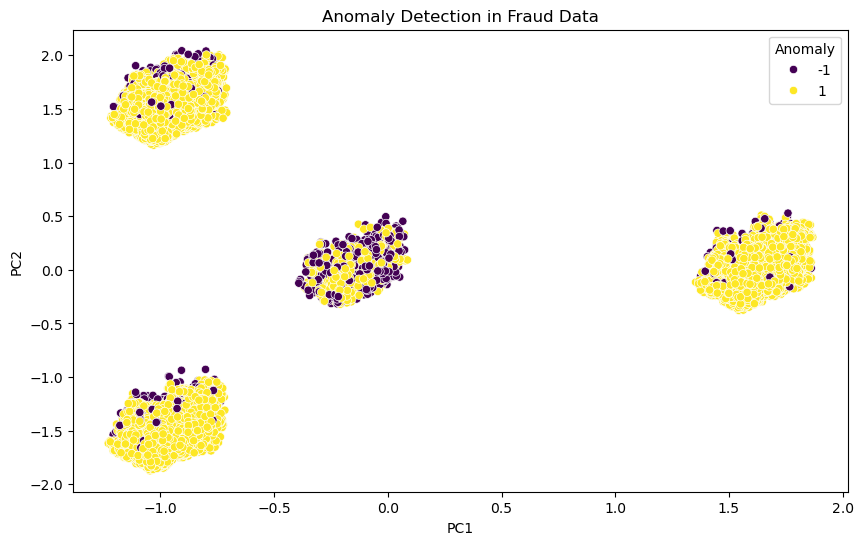

In [208]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='PC1', y='PC2', hue='Anomaly', data=df, palette='viridis')
plt.title('Anomaly Detection in Fraud Data')
plt.show()

In [209]:
print(df['Anomaly'].value_counts())

Anomaly
 1    48450
-1     2550
Name: count, dtype: int64


### Evaluation (Optional)

In [210]:
# Remap anomaly labels (1 for normal, -1 for anomaly)
anomaly_labels = [1 if x == 1 else 0 for x in anomalies]

In [211]:
# Convert 'Fraudulent' column to match anomaly labels (1 for normal, 0 for fraud)
fraudulent_labels = 1 - df['Fraudulent']

In [212]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score

# Define the metrics 
precision = precision_score(fraudulent_labels, anomaly_labels)
recall = recall_score(fraudulent_labels, anomaly_labels)
f1 = f1_score(fraudulent_labels, anomaly_labels)
auc_roc = roc_auc_score(fraudulent_labels, anomaly_labels)

print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1-Score: {f1:.4f}')
print(f'AUC-ROC: {auc_roc:.4f}')

Precision: 0.9786
Recall: 0.9778
F1-Score: 0.9782
AUC-ROC: 0.7825


In [213]:
from sklearn.metrics import classification_report, confusion_matrix

# Classification Report
print("Classification Report:")
print(classification_report(fraudulent_labels, anomaly_labels))

Classification Report:
              precision    recall  f1-score   support

           0       0.58      0.59      0.58      2510
           1       0.98      0.98      0.98     48490

    accuracy                           0.96     51000
   macro avg       0.78      0.78      0.78     51000
weighted avg       0.96      0.96      0.96     51000



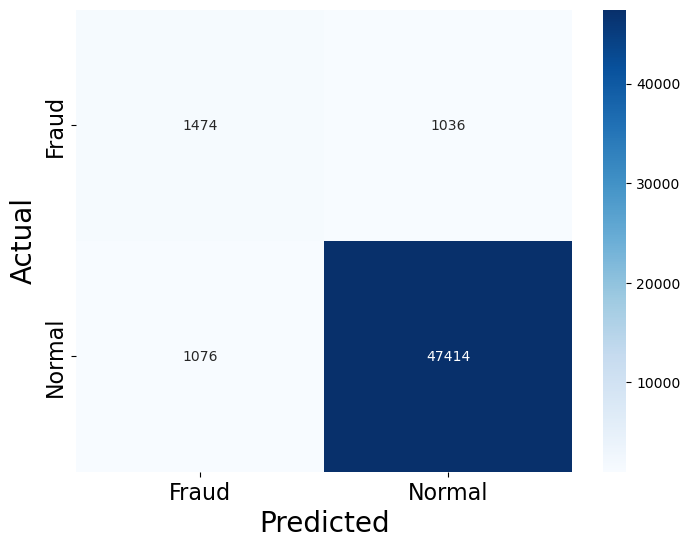

In [214]:
# Confusion Matrix Heatmap
cm = confusion_matrix(fraudulent_labels, anomaly_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Fraud', 'Normal'],
            yticklabels=['Fraud', 'Normal'])
plt.xlabel('Predicted', fontsize = 20)
plt.ylabel('Actual', fontsize = 20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
#plt.title('Confusion Matrix')
plt.show()

### Exercise

Discuss the findings and Implications 

How can the Model be improve to detect fraud? 